## **AAI EXPERIMENT NO - 4**

### **Aim - Build and Train a Generative Multi-Layer Network Model**

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 46ms/step - d_loss: 0.2158 - g_loss: 3.3893
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 48ms/step - d_loss: 0.0988 - g_loss: 3.8214
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - d_loss: 0.0732 - g_loss: 5.3056
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - d_loss: 0.0553 - g_loss: 5.9333
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 46ms/step - d_loss: 0.0529 - g_loss: 6.1102
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - d_loss: 0.0676 - g_loss: 6.3960
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - d_loss: 0.0358 - g_loss: 5.9425
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - d_loss: 0.0628 - g_loss: 7.0129
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 49ms/step - d_loss: 0.0549 - g_loss: 7.1683
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - d_loss: 0.0454 - g_loss: 7.4044
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - d_loss: 0.0403 - g_loss: 7.3569
Epoch 12/50
469/469 ━━━━━━━━━━

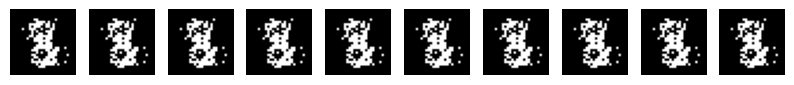

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

latent_dim = 100
img_shape = (28, 28, 1)

def build_generator():
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(np.prod(img_shape), activation='sigmoid'),
        layers.Reshape(img_shape)
    ])
    return model

generator = build_generator()

def build_discriminator():
    model = keras.Sequential([
        layers.Flatten(input_shape=img_shape),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

discriminator = build_discriminator()

discriminator.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

class GAN(keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(GAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
        generated_images = self.generator(random_latent_vectors)

        real_labels = tf.ones((batch_size, 1))
        fake_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            real_loss = self.loss_fn(real_labels, self.discriminator(real_images))
            fake_loss = self.loss_fn(fake_labels, self.discriminator(generated_images))
            d_loss = (real_loss + fake_loss) / 2

        d_grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

        random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as tape:
            g_loss = self.loss_fn(misleading_labels, self.discriminator(self.generator(random_latent_vectors)))

        g_grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}

gan = GAN(generator, discriminator)
gan.compile(
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy()
)

(x_train, _), (_, _) = keras.datasets.mnist.load_data()
x_train = (x_train.astype("float32") / 255.0).reshape(-1, 28, 28, 1)

gan.fit(x_train, epochs=50, batch_size=128)

random_latent_vectors = np.random.normal(size=(10, latent_dim))
generated_images = generator.predict(random_latent_vectors)

fig, axes = plt.subplots(1, 10, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(generated_images[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.show()
